# Gesture Recognition

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

# Import the Libraries

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import cv2
import matplotlib.pyplot as plt
import _pickle as pickle
% matplotlib inline

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


Using TensorFlow backend.


In [3]:
try:
  tf.random.set_seed(30)
  print(f"Info: Tensorflow Version {tf.__version__}")
except:
  tf.set_random_seed(30)
  print(f"Info: Tensorflow Version {tf.__version__}")

Info: Tensorflow Version 1.10.0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open(r'./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'./Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

# Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches

        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes = 5 # Number of classes left swipe, right swipe, thumbs up, thumbs down, stop
print ('# Number of classes =', num_classes)

# epochs = 10
# Number of classes = 5


In [7]:
curr_dt_time = datetime.datetime.now()
train_path = r'./Project_data/train'
val_path = r'./Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


# Model 1

Here we have made the model using different functionalities that Keras provides. Use of `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would use `BatchNormalization` while building model. Also remember that the last layer is the softmax.

In [8]:
model = Sequential()
model.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(x, y, z, 3),
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(num_classes, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:
opt = optimizers.Adam()#write your optimizer
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 15, 60, 60, 16)    0         
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model1_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:
if not os.path.exists("results/"):
    os.mkdir("results/")

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
hist = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save model history for plotting
with open('results/'+model_name[:-1]+".pickle", 'wb') as f:
    pickle.dump(hist.history, f)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - 81s 4s/step - loss: 4.2890 - categorical_accuracy: 0.2620 - val_loss: 2.5842 - val_categorical_accuracy: 0.2700

Epoch 00001: saving model to model1__2020-12-2808_50_37.712513/model-00001-4.31115-0.26094-2.58420-0.27000.h5
Epoch 2/10
21/21 [==============================] - 52s 2s/step - loss: 1.9798 - categorical_accuracy: 0.3478 - val_loss: 2.0773 - val_categorical_accuracy: 0.3750

Epoch 00002: saving model to model1__2020-12-2808_50_37.712513/model-00002-1.97982-0.34783-2.07731-0.37500.h5
Epoch 3/10
21/21 [==============================] - 45s 2s/step - loss: 1.5152 - categorical_accuracy: 0.4007 - val_loss: 1.2167 - val_categorical_accuracy: 0.3750

Epoch 00003: saving model to model1__2020-12-2808_50_37.712513/model-00003-1.52164-0.40047-1.21673-0.37500.h5
Epoch 4/10
21/21 [==============================] - 44s 2s/step - los

In [25]:
# One Time Util function to plot loss and accuracy
def plot_loss_acc(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

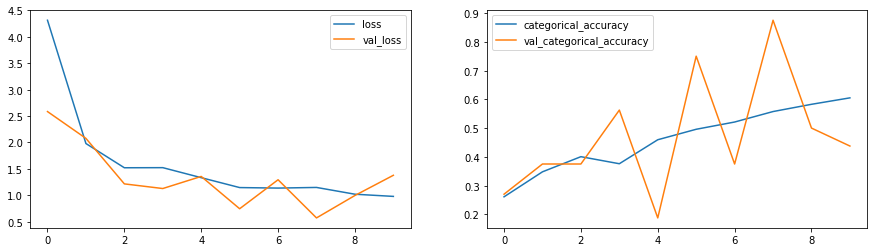

In [16]:
plot_loss_acc(hist)

# Now we will change the value of x, y & z to check if the accuracy is increasing or not

In [17]:
x = 30 # number of frames
y = 60 # image width
z = 60 # image height
channel = 3

# Model 2

In [18]:
# Creating model 2
model2 = Sequential()
model2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(x,y,z,3),
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

model2.add(Conv3D(64, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model2.add(Flatten())
model2.add(Dense(1000, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(500, activation='relu'))
model2.add(Dropout(0.5))

#softmax layer
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 30, 60, 60, 8)     656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 60, 60, 8)     32        
_________________________________________________________________
activation_5 (Activation)    (None, 30, 60, 60, 8)     0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 15, 30, 30, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 15, 30, 30, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 30, 30, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 15, 30, 30, 16)    0         
__________

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model2_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [21]:
hist = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save model for plotting
with open('results/'+model_name[:-1]+".pickle", 'wb') as f:
    pickle.dump(hist.history, f)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - 68s 3s/step - loss: 2.1243 - categorical_accuracy: 0.3076 - val_loss: 1.7537 - val_categorical_accuracy: 0.3300

Epoch 00001: saving model to model2__2020-12-2808_50_37.712513/model-00001-2.12628-0.30769-1.75375-0.33000.h5
Epoch 2/10
21/21 [==============================] - 44s 2s/step - loss: 1.5031 - categorical_accuracy: 0.3892 - val_loss: 1.2255 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model2__2020-12-2808_50_37.712513/model-00002-1.50313-0.38923-1.22552-0.50000.h5
Epoch 3/10
21/21 [==============================] - 41s 2s/step - loss: 1.3151 - categorical_accuracy: 0.4198 - val_loss: 1.1628 - val_categorical_accuracy: 0.4375

Epoch 00003: saving model to model2__2020-12-2808_50_37.712513/model-00003-1.31297-0.42155-1.16278-0.43750.h5
Epoch 4/10
21/21 [==============================] - 39s 2s/step - los

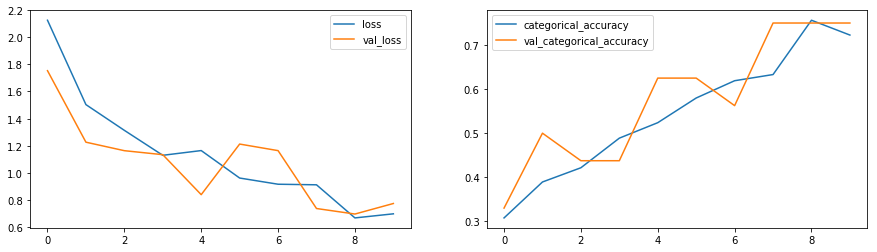

In [22]:
plot_loss_acc(hist)

## Model 3 

Lets change the batch size to 64 and see if it makes any difference

In [23]:
batch_size = 64

In [24]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [25]:
model_name = 'model3_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [26]:
# Creating model 3
model3 = Sequential()
model3.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=(x,y,z,3),
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

model3.add(Conv3D(64, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model3.add(Flatten())
model3.add(Dense(1000, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(500, activation='relu'))
model3.add(Dropout(0.5))

#softmax layer
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 60, 60, 8)     656       
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 60, 60, 8)     32        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 60, 60, 8)     0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 15, 30, 30, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 30, 30, 16)    3472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 15, 30, 30, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 30, 30, 16)    0         
__________

In [27]:
# Using the same model just changing the batch size and trying
hist = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save model for plotting
with open('results/'+model_name[:-1]+".pickle", 'wb') as f:
    pickle.dump(hist.history, f)
    

Source path =  ./Project_data/val ; batch size = 64
Source path =  ./Project_data/train ; batch size = 64
Epoch 1/10
Batch:  2 Index: 64
21/21 [==============================] - 94s 4s/step - loss: 1.8188 - categorical_accuracy: 0.3493 - val_loss: 1.5761 - val_categorical_accuracy: 0.3256

Epoch 00001: saving model to model3__2020-12-2808_50_37.712513/model-00001-1.91718-0.31467-1.57609-0.32558.h5
Epoch 2/10
21/21 [==============================] - 47s 2s/step - loss: 1.4337 - categorical_accuracy: 0.4092 - val_loss: 1.1627 - val_categorical_accuracy: 0.4911

Epoch 00002: saving model to model3__2020-12-2808_50_37.712513/model-00002-1.44056-0.40764-1.16271-0.49107.h5
Epoch 3/10
Batch:  7 Index: 16
21/21 [==============================] - 39s 2s/step - loss: 1.2169 - categorical_accuracy: 0.4762 - val_loss: 1.3371 - val_categorical_accuracy: 0.4219

Epoch 00003: saving model to model3__2020-12-2808_50_37.712513/model-00003-1.21686-0.47619-1.33713-0.42188.h5
Epoch 4/10
21/21 [===========

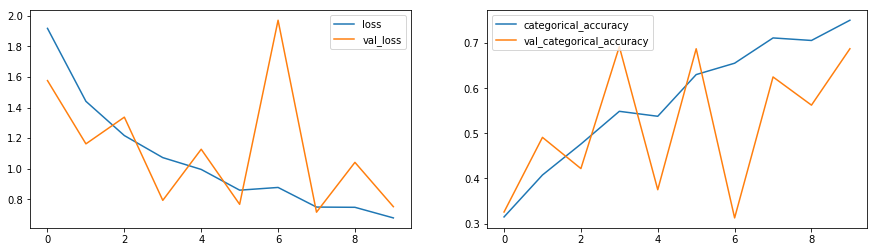

In [28]:
plot_loss_acc(hist)

# Model 4

In [30]:
nb_filters ,nb_dense= [8,16,32,64],[256, 128, 5]

# Input
input_shape=(x,y,z,3)

# Define model
model4 = Sequential()
model4.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

model4.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model4.add(Flatten())
model4.add(Dense(nb_dense[0], activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(nb_dense[1], activation='relu'))
model4.add(Dropout(0.5))

#softmax layer
model4.add(Dense(nb_dense[2], activation='softmax'))

model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 30, 60, 60, 8)     656       
_________________________________________________________________
batch_normalization_16 (Batc (None, 30, 60, 60, 8)     32        
_________________________________________________________________
activation_17 (Activation)   (None, 30, 60, 60, 8)     0         
_________________________________________________________________
max_pooling3d_17 (MaxPooling (None, 15, 30, 30, 8)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 15, 30, 30, 16)    3472      
_________________________________________________________________
batch_normalization_17 (Batc (None, 15, 30, 30, 16)    64        
_________________________________________________________________
activation_18 (Activation)   (None, 15, 30, 30, 16)    0         
__________

In [31]:
model_name = 'model4_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [32]:
hist = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save model for plotting
with open('results/'+model_name[:-1]+".pickle", 'wb') as f:
    pickle.dump(hist.history, f)

Epoch 1/10
21/21 [==============================] - 36s 2s/step - loss: 2.1135 - categorical_accuracy: 0.2353 - val_loss: 1.5222 - val_categorical_accuracy: 0.4375

Epoch 00001: saving model to model4__2020-12-2808_50_37.712513/model-00001-2.11345-0.23529-1.52221-0.43750.h5
Epoch 2/10
21/21 [==============================] - 33s 2s/step - loss: 1.6184 - categorical_accuracy: 0.2661 - val_loss: 1.5369 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to model4__2020-12-2808_50_37.712513/model-00002-1.61837-0.26611-1.53694-0.18750.h5
Epoch 3/10
21/21 [==============================] - 33s 2s/step - loss: 1.6154 - categorical_accuracy: 0.2857 - val_loss: 1.5234 - val_categorical_accuracy: 0.3125

Epoch 00003: saving model to model4__2020-12-2808_50_37.712513/model-00003-1.61538-0.28571-1.52339-0.31250.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 4/10
21/21 [==============================] - 34s 2s/step - loss: 1.5315 - categorical_ac

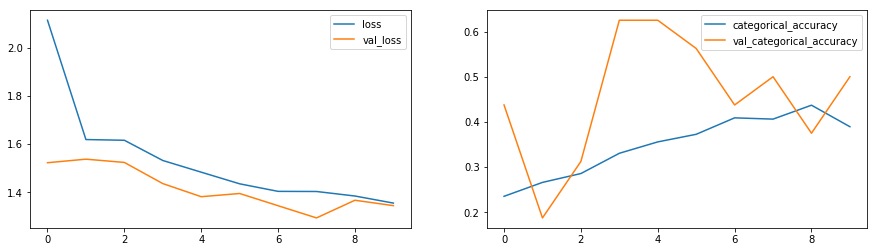

In [33]:
plot_loss_acc(hist)

# Model 5
Data Augmentation and GRU RNN

In [34]:
def generator_with_augmentation(source_path, folder_list, batch_size,augment):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    x = 18 # number of frames
    y = 120 # image width
    z = 120 # image height
    img_idx =  [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            if (augment):
                batch_data_aug = np.zeros((batch_size,x,y,z,3))                
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(y,z))
                    #temp = temp/127.5-1
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])/255 #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=shifted[x0:x1,y0:y1,:]
                    
                        image_resized= resize(cropped,(y,z,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
            
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            if (augment):
                batch_data_aug = np.zeros((batch_size,x,y,z,3))                
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(y,z))
                    #temp = temp/127.5-1
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])/255#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])/255 #normalise and feed in the image
                    
                    if (augment):
                        shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                        gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                        x0, y0 = np.argwhere(gray > 0).min(axis=0)
                        x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                        cropped=shifted[x0:x1,y0:y1,:]
                    
                        image_resized= resize(cropped,(y,z,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                        batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                        batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                        batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                    
            
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if (augment):
                batch_data=np.concatenate([batch_data,batch_data_aug])
                batch_labels=np.concatenate([batch_labels,batch_labels])
            
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

In [35]:
curr_dt_time = datetime.datetime.now()
train_path = r'./Project_data/train'
val_path = r'./Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [18]:
from keras.layers.convolutional import Conv2D,MaxPooling2D
from skimage.transform import resize

In [37]:
lstm_cells=128
nb_dense=128
dropout=0.25

model5 = Sequential()
model5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(18,120,120,3)))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model5.add(TimeDistributed(Flatten()))
model5.add(GRU(lstm_cells))
model5.add(Dropout(dropout))        
model5.add(Dense(nb_dense,activation='relu'))
model5.add(Dropout(dropout))        
model5.add(Dense(num_classes, activation='softmax'))


In [38]:
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 30, 30, 64)    18496     
__________

In [39]:
batch_size = 32 #64 causing memory issues

In [40]:
train_generator = generator_with_augmentation(train_path, train_doc, batch_size,augment=True)
val_generator = generator_with_augmentation(val_path, val_doc, batch_size,augment=False)

In [41]:
model_name = 'model5_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [42]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [43]:
hist = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

# save model for plotting
with open('results/'+model_name[:-1]+".pickle", 'wb') as f:
    pickle.dump(hist.history, f)

Source path =  ./Project_data/val ; batch size = 32
Source path =  ./Project_data/train ; batch size =Epoch 1/10 32

Batch:  4 Index: 32
21/21 [==============================] - 172s 8s/step - loss: 1.5532 - categorical_accuracy: 0.3103 - val_loss: 1.2464 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model5__2020-12-2809_23_47.936997/model-00001-1.55706-0.30845-1.24638-0.48000.h5
Epoch 2/10
21/21 [==============================] - 107s 5s/step - loss: 1.0808 - categorical_accuracy: 0.5497 - val_loss: 1.3208 - val_categorical_accuracy: 0.3125

Epoch 00002: saving model to model5__2020-12-2809_23_47.936997/model-00002-1.08085-0.54969-1.32077-0.31250.h5
Epoch 3/10
21/21 [==============================] - 100s 5s/step - loss: 1.0459 - categorical_accuracy: 0.5827 - val_loss: 1.0778 - val_categorical_accuracy: 0.5625

Epoch 00003: saving model to model5__2020-12-2809_23_47.936997/model-00003-1.05262-0.57963-1.07776-0.56250.h5
Epoch 4/10
21/21 [============================

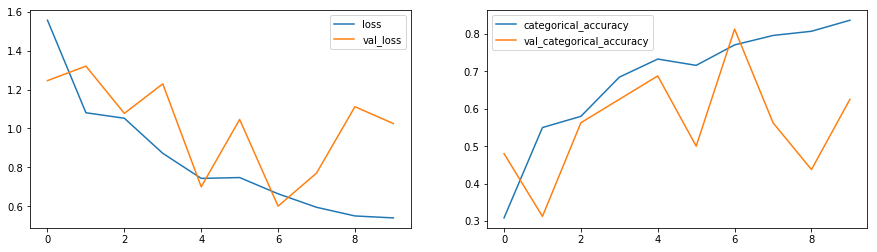

In [44]:
plot_loss_acc(hist)

# Model 6 
Transfer learning with Mobilenet model

In [45]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [48]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

In [49]:
model_6 = Sequential()
model_6.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

model_6.add(TimeDistributed(BatchNormalization()))
model_6.add(TimeDistributed(MaxPooling2D((2, 2))))
model_6.add(TimeDistributed(Flatten()))

model_6.add(GRU(128))
model_6.add(Dropout(0.25))

model_6.add(Dense(128,activation='relu'))
model_6.add(Dropout(0.25))

model_6.add(Dense(num_classes, activation='softmax'))

model_6.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model_6.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
__________

In [50]:
batch_size = 10 # batch_size higher not supporting Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

In [51]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [52]:
model_name = 'model6_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [53]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [54]:
hist = model_6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
# save model for plotting
with open('results/'+model_name[:-1]+".pickle", 'wb') as f:
    pickle.dump(hist.history, f)

Source path =  ./Project_data/val ; batch size = 10
Source path =  ./Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 88s 1s/step - loss: 1.7133 - categorical_accuracy: 0.2523 - val_loss: 1.3089 - val_categorical_accuracy: 0.5200

Epoch 00001: saving model to model6__2020-12-2809_23_47.936997/model-00001-1.71098-0.25490-1.30895-0.52000.h5
Epoch 2/10
67/67 [==============================] - 28s 424ms/step - loss: 1.4515 - categorical_accuracy: 0.3682 - val_loss: 1.1979 - val_categorical_accuracy: 0.6600

Epoch 00002: saving model to model6__2020-12-2809_23_47.936997/model-00002-1.45153-0.36816-1.19795-0.66000.h5
Epoch 3/10
67/67 [==============================] - 28s 425ms/step - loss: 1.4470 - categorical_accuracy: 0.3731 - val_loss: 1.1456 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model6__2020-12-2809_23_47.936997/model-00003-1.44702-0.37313-1.14556-0.60000.h5
Epoch 4/10
67/67 [==============================] - 29s 426ms/s

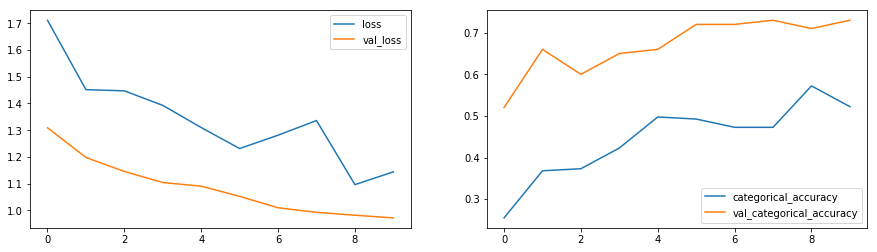

In [55]:
plot_loss_acc(hist)

# Plotting all models

In [56]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item.split("/")[1].split("_")[0] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]

valid_acc = [pickle.load( open( i, "rb" ) )['val_categorical_accuracy'] for i in all_pickles]
train_acc = [pickle.load( open( i, "rb" ) )['categorical_accuracy'] for i in all_pickles]

# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]


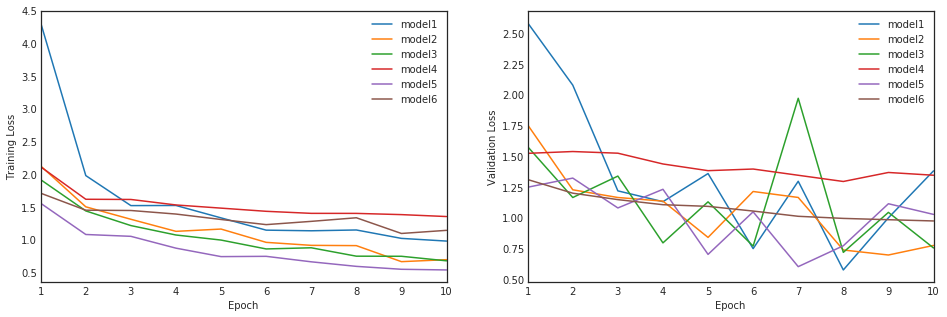

In [57]:
fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()


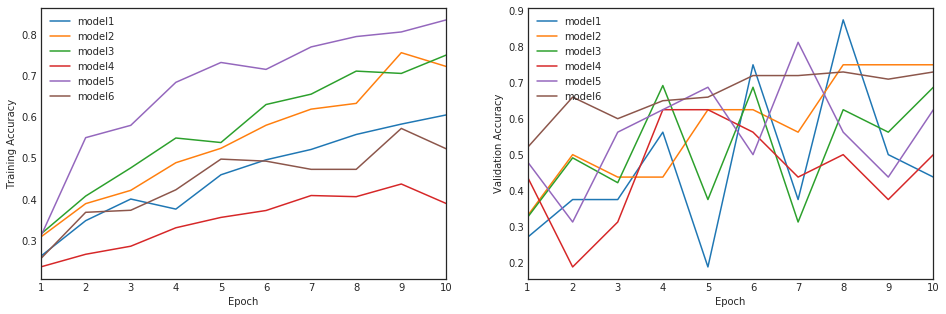

In [58]:
fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_acc[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_acc[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()


# Final Model

From above analysis picked transfer learning as best model and training it.

In [11]:
from keras.applications import mobilenet
pretrained_mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

17227776/17225924 [==============================] - 2s 0us/step


In [16]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height
channel = 3

In [15]:
batch_size = 10
opt = optimizers.Adam()

In [19]:
final_model = Sequential()
final_model.add(TimeDistributed(pretrained_mobilenet,input_shape=(x,y,z,channel)))

final_model.add(TimeDistributed(BatchNormalization()))
final_model.add(TimeDistributed(MaxPooling2D((2, 2))))
final_model.add(TimeDistributed(Flatten()))

final_model.add(GRU(128))
final_model.add(Dropout(0.25))

final_model.add(Dense(128,activation='relu'))
final_model.add(Dropout(0.25))

final_model.add(Dense(num_classes, activation='softmax'))

final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(final_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, 30, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               442752    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
__________

In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [21]:
model_name = 'Finalmodel_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
hist = final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
# save model for plotting
with open('results/'+model_name[:-1]+".pickle", 'wb') as f:
    pickle.dump(hist.history, f)

Source path =  ./Project_data/val ; batch size = 10
Source path =  Epoch 1/50./Project_data/train ; batch size = 10

67/67 [==============================] - 193s 3s/step - loss: 1.1984 - categorical_accuracy: 0.5174 - val_loss: 1.2508 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to Finalmodel__2020-12-2810_24_32.692121/model-00001-1.20228-0.51584-1.25084-0.54000.h5
Epoch 2/50
67/67 [==============================] - 29s 439ms/step - loss: 1.1957 - categorical_accuracy: 0.5672 - val_loss: 1.3631 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to Finalmodel__2020-12-2810_24_32.692121/model-00002-1.19571-0.56716-1.36311-0.50000.h5
Epoch 3/50
67/67 [==============================] - 30s 448ms/step - loss: 1.2600 - categorical_accuracy: 0.4975 - val_loss: 1.0670 - val_categorical_accuracy: 0.4800

Epoch 00003: saving model to Finalmodel__2020-12-2810_24_32.692121/model-00003-1.26004-0.49751-1.06696-0.48000.h5
Epoch 4/50
67/67 [==============================] 

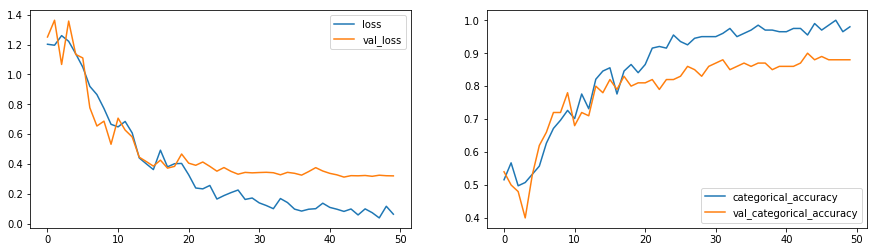

In [26]:
plot_loss_acc(hist)